## Libraries 

In [1]:
import re
import numpy as np
import sys
import matplotlib.pyplot as plt 

np.random.seed(3)

## Data

In [2]:
filepath = 'Data/CTR.txt'

def read_data ( data_path = filepath ) : 
    
    X , Y = [] , []
    with open(filepath) as f:
        lineList = f.readlines()
        for line in lineList :
            temp = np.array ( re.split(';|:',line)[1:] , dtype=np.float64 )
            X.append (temp[:5])
            Y.append (temp[5:])  
            
    return np.array(X) , np.array(Y) 

X , Y  = read_data ( filepath )

In [3]:
print("X : 'Context' shape confirmation : excpected = (5000,5) returned  = " , X.shape )
print("Y : 'Rewards' shape confirmation : excpected = (5000,10) returned = " , Y.shape )

X : 'Context' shape confirmation : excpected = (5000,5) returned  =  (5000, 5)
Y : 'Rewards' shape confirmation : excpected = (5000,10) returned =  (5000, 10)


## 3 Baselines

In [4]:
np.random.seed (0)

def Random ( Y ) :
    return np.random.randint( 0 , high=Y.shape[1] , size=Y.shape[0] )

def Cumulative_Best( Y ):
    return np.argmax ( np.cumsum(Y,axis=0) , axis=1 ) 

def Optimal ( Y ) :
    return Y.argmax(1)

In [5]:
res1 = Random( Y )
print ( "shape ", res1.shape , " result : " , res1 )

shape  (5000,)  result :  [5 0 3 ... 6 2 9]


In [6]:
res2 = Cumulative_Best( Y )
print ( "shape ", res2.shape , " result : " , res2 )

shape  (5000,)  result :  [6 9 9 ... 3 3 3]


In [7]:
res3 = Optimal( Y )
print ( "shape ", res3.shape , " result : " , res3 )

shape  (5000,)  result :  [6 9 9 ... 3 1 3]


## UCB [Auer et al., 2002] and UCB-V [Audibert et al., 2007]


In [8]:
def UCB ( Y , V=False ) : 
    
    '''
    Y : Rewards ( t , arms )
    V : UCB-V  ( empirical variance bound)
    '''
    
    ######## init ######## 
    # number of iterations
    T = Y.shape[0]
    # number of arms 
    N = Y.shape[1]
    
    reward_cumsum_arms       = np.zeros(N)
    reward_cumsumsqrt_arms   = np.zeros(N)
    selection_arms           = np.ones(N)
    selected_arms , rewards  = [],[]
    #######################
    
    ######## UCB Strategy ###########
    for t in range ( T ) :
        # avg + delta 
        avg = (reward_cumsum_arms/selection_arms)
        if ( V ) : 
            variance = ( reward_cumsumsqrt_arms/selection_arms ) - ( avg**2 )
            delta    = np.sqrt(2*np.log(t+1)*variance / selection_arms) + ( np.log(t+1) / (2*selection_arms) )
        else :
            delta = np.sqrt ( 2*np.log(t+1) / selection_arms )
            
        scores = avg + delta
        selected_arm = scores.argmax()
        # update tracking informations 
        selected_arms.append(selected_arm)
        rewards.append(Y[t,selected_arm])
        selection_arms[ selected_arm ] += 1
        reward_cumsum_arms[ selected_arm ] += Y[t,selected_arm]
        reward_cumsumsqrt_arms[ selected_arm ] += (Y[t,selected_arm]**2)
    ######## UCB Strategy ###########  
   
    return np.array(selected_arms)

# Linear UCB [Li et al., 2010]

In [9]:
def LinUCB ( X , Y , alpha=0.5  ) : 
    
    ######## init ######## 
    # number of iterations
    T = Y.shape[0]
    # number of arms 
    N = Y.shape[1]
    # d : context dimension
    d = X.shape[1]
    
    arms = np.arange(N)
    A = np.zeros( (N,d,d) )
    b = np.zeros( (N,d) )
    params = np.random.randn( N,d )
    predicted_reward = np.zeros (N)
    
    new = [True] * N
    
    selected_arms , rewards  = [],[]
    #######################
    for t in range ( T ) : 
        for a in arms :
            if ( new[a] ) :
                A[a] = np.identity(d)
                new[a] = False
            
            inverse_Aa = np.linalg.inv(A[a])
            params[a] = inverse_Aa @ b[a]
            predicted_reward[a] = params[a] @ X[t] + alpha * np.sqrt( X[t].T @ inverse_Aa @ X[t] )
              
        selected_arm = np.random.choice ( np.where (predicted_reward==predicted_reward.max())[0] )
        A[selected_arm] = A[selected_arm] +  X[t] @ X[t].T
        b[selected_arm] = b[selected_arm] +  Y[t,selected_arm] * X[t]
        
        selected_arms.append( selected_arm )
        rewards.append( Y[t,selected_arm] )
        
    return np.array(selected_arms)


## Evaluation 

In [10]:
def get_cum_rewards (  real_rewards , res_strategy  ) :
    return (real_rewards [ np.arange(len(res_strategy)) , res_strategy ]).cumsum()

def get_regrets (  real_rewards , res_strategy  ) :
    return (real_rewards [ np.arange(len(res_strategy)) , res_strategy ]).cumsum()

In [11]:
%%time 

# cumulative rewards
cum_random =  get_cum_rewards ( Y , Random ( Y ) ) 
cum_optimal=  get_cum_rewards ( Y , Optimal ( Y ) )  
cum_best   =  get_cum_rewards ( Y , Cumulative_Best ( Y ) )  
cum_UCB    =  get_cum_rewards ( Y , UCB ( Y ) )  
cum_UCBV   =  get_cum_rewards ( Y , UCB ( Y , V=True ) ) 
cum_LinUCB =  get_cum_rewards ( Y , LinUCB ( X , Y , alpha = 10 ) )  


Wall time: 1.31 s


In [12]:
T = np.arange(Y.shape[0])

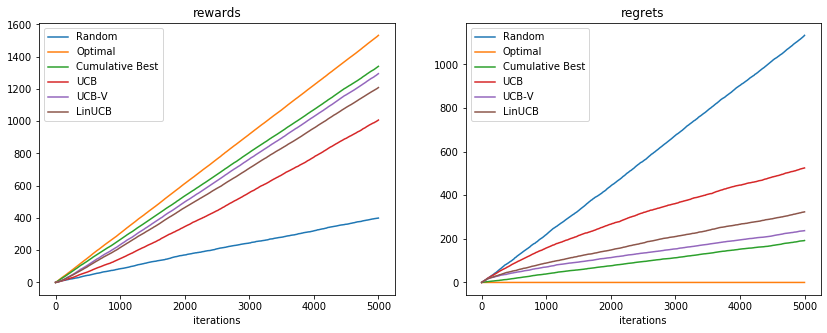

In [13]:


plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot( T , cum_random  , label="Random" )
plt.plot( T , cum_optimal , label="Optimal" )
plt.plot( T , cum_best    , label="Cumulative Best" )
plt.plot( T , cum_UCB     , label="UCB" )
plt.plot( T , cum_UCBV    , label="UCB-V" )
plt.plot( T , cum_LinUCB   , label="LinUCB" )
plt.xlabel('iterations')
plt.title("rewards")
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot( T , cum_optimal - cum_random  , label="Random" )
## added to not loose colors matching
plt.plot( T , cum_optimal - cum_optimal , label="Optimal" )
plt.plot( T , cum_optimal - cum_best    , label="Cumulative Best" )
plt.plot( T , cum_optimal - cum_UCB     , label="UCB" )
plt.plot( T , cum_optimal - cum_UCBV    , label="UCB-V" )
plt.plot( T , cum_optimal - cum_LinUCB  , label="LinUCB" )
plt.xlabel('iterations')
plt.title("regrets")
plt.legend(loc="best")


plt.show()

In [14]:
alphas = [ (10**i)  for i in range (-4,4) ]

cum_LinUCB_alphas = { alpha : get_cum_rewards ( Y , LinUCB ( X , Y , alpha )  ) for alpha in alphas  }

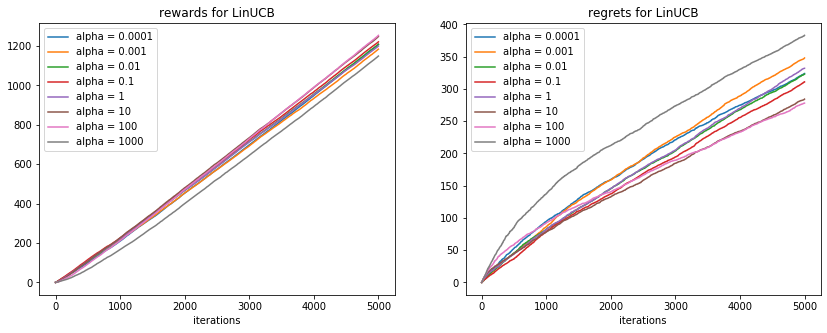

In [15]:


plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
for  alpha in alphas :
    plt.plot( T , cum_LinUCB_alphas[alpha]  , label="alpha = "+str(alpha) )
plt.xlabel('iterations')
plt.title("rewards for LinUCB")
plt.legend(loc="best")

plt.subplot(1,2,2)
for  alpha in alphas :
    plt.plot( T , cum_optimal-cum_LinUCB_alphas[alpha]  , label="alpha = "+str(alpha) )

plt.xlabel('iterations')
plt.title("regrets for LinUCB")
plt.legend(loc="best")


plt.show()

In [16]:
print ("Best alpha : ",alphas [np.array(list(cum_LinUCB_alphas.values()))[:,-1].argmax()] )

Best alpha :  100


# References

**[1] [Li et al., 2010] Lihong Li, Wei Chu, John Langford, and Robert E. Schapire. 2010. A contextual-bandit
approach to personalized news article recommendation. In Proceedings of the 19th international conference
on World wide web (WWW ’10). ACM, New York, NY, USA, 661-670.**

**[2] [Audibert et al., 2007] J.-Y. Audibert, R. Munos, and C. Szepesvari. Tuning bandit algorithms in stochastic
environments. In ALT’07, pages 150–165. 2007.**

**[3] [Auer et al., 2002] Peter Auer, Nicolo Cesa-Bianchi, and Paul Fischer. 2002. Finite-time Analysis of the
Multiarmed Bandit Problem. Mach. Learn. 47, 2-3 (May 2002), 235-256.**